In [1]:
import sys
sys.path.append('../modules/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
from mymodule_2 import *
from mymodule2_2 import *
from pulp_func_2 import *
df2023_result = pd.read_excel('../excels/附件3/2023_result.xlsx')
# 去除列名末尾的空格。很奇怪
df2023_result.columns = [column.rstrip(' ') for column in df2023_result.columns]
# print(df2023_result)

In [2]:
# 数据准备

merged_df = get_merged_df(df21, df22)
# print(merged_df)
total_yield_2023 = merged_df.groupby(['作物编号', '作物名称'])['单地块类型总产量/斤'].sum().reset_index()
total_yield_2023.columns = ['作物编号', '作物名称', '总产量/斤']
# print(total_yield_2023)
expected_sales_data_2023 = total_yield_2023.copy()
expected_sales_data_2023.columns = ['作物编号', '作物名称', '预期销售量/斤']

# 按照 '作物编号' 和 '作物名称' 进行分组，并对 '利润' 进行求和
total_profit = merged_df.groupby(['作物编号', '作物名称'])[['利润', '每亩利润']].sum().reset_index()
# 重命名列，以便清晰地表示数据
total_profit.columns = ['作物编号', '作物名称', '总利润/元', '每亩总利润/元']
# 打印 total_profit
# print(total_profit)
total_profit_2023 = total_profit['总利润/元'].sum()
# print("总利润/元的和:", total_profit_2023)
std_devs = [0.005, 0.005, 0.01, 0.01, 0.003, 0.003, 0.003, 0.003]
past_profits = [total_profit_2023]

fields = create_fields(df11)
# for field in fields:
#     print(field)
new_fields = create_new_fields(fields)
# for field in new_fields:
#     print(field)

In [6]:
mc = 1 # 蒙特卡洛模拟次数
weights = [0.7, 0.3] # 分数计算权重
k = 0.5
min_area_percent = 0.2
max_plots = 4
total_score_max = 0
total_score_i_list = []
scores_max = []
profits_max = [] # 这里指的是分数最高时的利润，而不是利润最高
total_profit_i_list = []
stability_max = [] # 这里指的是分数最高时的稳定性（不稳定性），而不是稳定性最高
total_stability_i_list = []
for i in range(mc): 
    # 每次蒙特卡洛模拟都要重新初始化数据
    df_template_list = []
    scores = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的得分
    profits = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的利润
    past_profits = [total_profit_2023] # 别忘了重置这个！其实这个和上面的profits是一样的，但已经这么设定了就不改了
    stabilitys = [0, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的稳定性分数（其实是不稳定性）
    expected_sales_data = total_yield_2023.copy() # 初始值为2023年的数据
    expected_sales_data.columns = ['作物编号', '作物名称', '预期销售量/斤']
    crops = create_crops(df12, df22)
    # 2024年

    # 更新数据
    expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
    crops = update_crops(crops, std_devs)

    variables, binary_variables, actual_sales, excess_yield = create_variables(new_fields, crops)
    # 创建线性规划问题
    prob = pulp.LpProblem("Crop_Planting_Optimization", pulp.LpMaximize)
    # 定义目标函数的各个部分
    profit = define_objective_function(variables, actual_sales, excess_yield, crops, new_fields, k)
    # 将目标函数添加到问题中
    prob += profit
    prob = add_constraints2(prob, variables, binary_variables, actual_sales, excess_yield,
                            crops, new_fields, total_yield_2023, df2023_result, min_area_percent, max_plots)

    # 求解问题
    prob.solve()
    print("Status:", pulp.LpStatus[prob.status])
    update_new_fields(variables, new_fields)
    df_template = pd.read_excel('../excels/附件3/template.xlsx')
    df_template_list.append(update_template(df_template, new_fields))


    objective_value = pulp.value(prob.objective)
    past_profits.append(objective_value)
    print("Objective Value / Profit:", objective_value)
    profits[1] = objective_value

    stability = calculate_stability(past_profits)
    print("Stability:", stability)
    stabilitys[1] = stability

    score_now = calculate_score(objective_value, stability, weights)
    print("Score:", score_now)
    scores[1] = score_now
    # 清空当年的种植信息
    for field in new_fields:
        field.planted_crop = []

    # 2025年到2030年

    for year in range(2025, 2031):
        list = [k, min_area_percent, max_plots, year]
        expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
        crops = update_crops(crops, std_devs)

        df_last1_result = pd.read_excel(f'../excels/附件3/{year - 1}_result_{k}.xlsx')
        df_last1_result.columns = [column.rstrip(' ') for column in df_last1_result.columns]
        if year - 2 == 2023:
            df_last2_result = pd.read_excel(f'../excels/附件3/2023_result.xlsx')
        else:    
            df_last2_result = pd.read_excel(f'../excels/附件3/{year - 2}_result_{k}.xlsx')
        df_last2_result.columns = [column.rstrip(' ') for column in df_last2_result.columns]

        objective_value = optimize_planting_strategy(new_fields, crops, expected_sales_data, df_last1_result, df_last2_result, list)
        df_template_list.append(update_template(df_template, new_fields))
        past_profits.append(objective_value)
        print("Objective Value / Profit:", objective_value)
        profits[year - 2023] = objective_value

        stability = calculate_stability(past_profits)
        print("Stability:", stability)
        stabilitys[year - 2023] = stability

        score_now = calculate_score(objective_value, stability, weights)
        scores[year - 2023] = score_now
        print("Score:", score_now)
        # 清空当年的种植信息
        for field in new_fields:
            field.planted_crop = []
    
    print("\nScores:", scores)
    total_score_i = sum(scores)
    total_score_i_list.append(total_score_i)
    print("Total Score:", total_score_i)
    print("\n")
    total_profit_i = sum(profits)
    total_stability_i = sum(stabilitys)
    total_profit_i_list.append(total_profit_i)
    total_stability_i_list.append(total_stability_i)

    if total_score_i > total_score_max:
        total_score_max = total_score_i
        scores_max = scores
        profits_max = profits
        stability_max = stabilitys
        for template in df_template_list:
            output(template, year, k)

print("Total Score Max:", total_score_max)
print("Total Score i List:", total_score_i_list)
print("Scores Max:", scores_max)
print("Profits Max:", profits_max)
print("Total Profit i List:", total_profit_i_list)
print("Stability Max:", stability_max)
print("Total Stability i List:", total_stability_i_list)

Status: Infeasible
Objective Value / Profit: 8710033.295244165
Stability: 0.0
Score: 6097023.306670915


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: -2387393.7895218055
Objective Value / Profit: -2387393.7895218055
Stability: 6940556.065005068
Score: -3753342.472166784
Status: Infeasible
Objective Function Value: 4818266.948444718
Objective Value / Profit: 4818266.948444718
Stability: 7797735.902452714
Score: 1033466.0931754881
Status: Infeasible
Objective Function Value: 6660262.793532583
Objective Value / Profit: 6660262.793532583
Stability: 6820586.999252784
Score: 2616007.8556969725
Status: Infeasible
Objective Function Value: 9975877.417226149
Objective Value / Profit: 9975877.417226149
Stability: 6227838.288433862
Score: 5114762.705528145
Status: Infeasible
Objective Function Value: 9215277.51763075
Objective Value / Profit: 9215277.51763075
Stability: 5715261.084961844
Score: 4736115.936852971
Status: Infeasible
Objective Function Value: 9697181.025811756
Objective Value / Profit: 9697181.025811756
Stability: 5291354.374621919
Score: 5200620.405681653

Scores: [5926348.25, 6097023

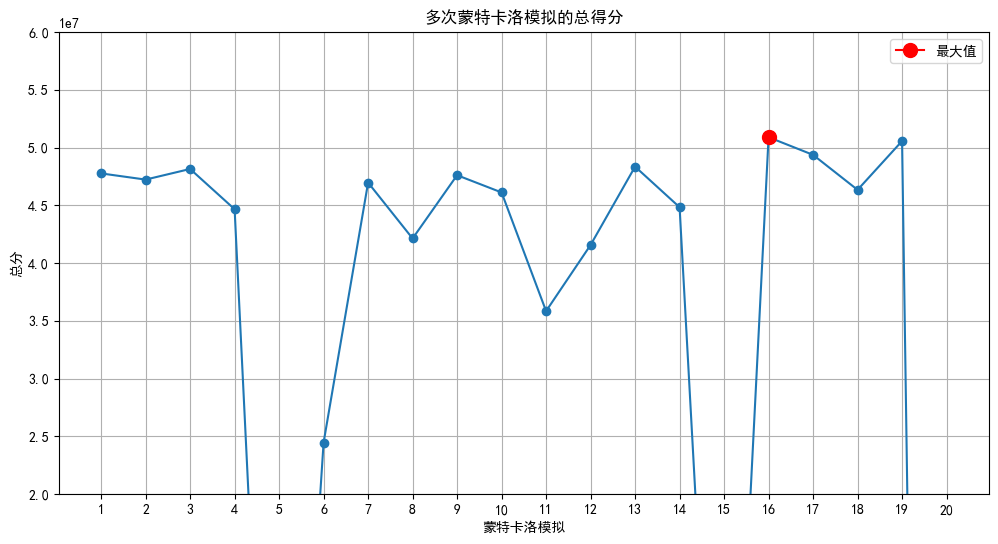

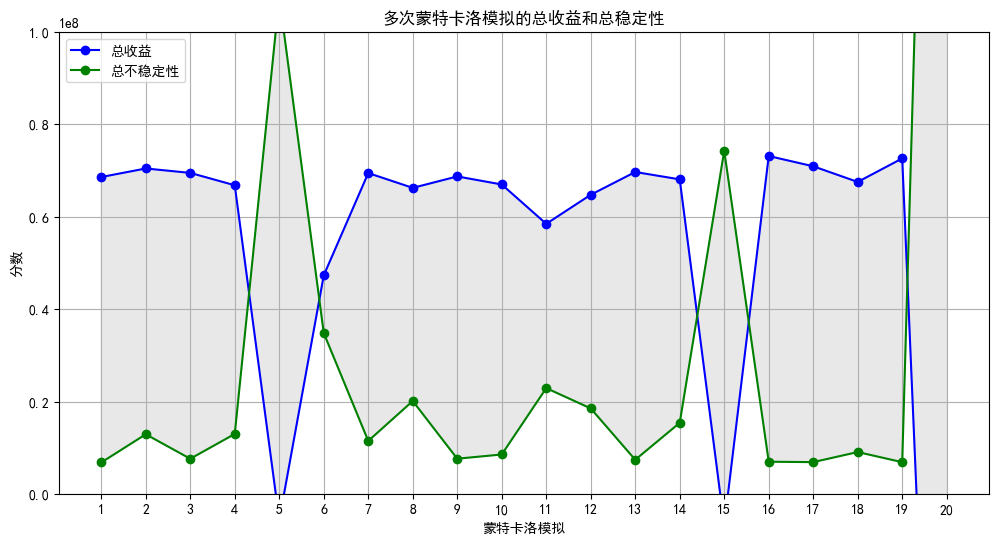

In [4]:
# 定义模拟次数
simulations = [i for i in range(1, mc + 1)]

# 绘制多次蒙特卡洛模拟的总得分折线图
plt.figure(figsize=(12, 6))
plt.plot(simulations, total_score_i_list, marker='o', linestyle='-')

# 找到最大值及其对应的模拟次数
max_score = max(total_score_i_list)
max_index = total_score_i_list.index(max_score)

# 标出最大值点
plt.plot(simulations[max_index], max_score, marker='o', markersize=10, color='red', label='最大值')

plt.title('多次蒙特卡洛模拟的总得分')
plt.xlabel('蒙特卡洛模拟')
plt.xticks(simulations)
plt.ylabel('总分')
plt.ylim(2e7, 6e7)
plt.legend()
plt.grid(True)
plt.show()

# 绘制总利润和总稳定性折线图
plt.figure(figsize=(12, 6))
plt.plot(simulations, total_profit_i_list, label='总收益', color='blue', marker='o', linestyle='-')
plt.plot(simulations, total_stability_i_list, label='总不稳定性', color='green', marker='o', linestyle='-')

# 在两条折线之间填充颜色
plt.fill_between(simulations, total_profit_i_list, total_stability_i_list, color='lightgray', alpha=0.5)

# 添加标题和标签
plt.title('多次蒙特卡洛模拟的总收益和总稳定性')
plt.xlabel('蒙特卡洛模拟')
plt.xticks(simulations)
plt.ylabel('分数')
plt.ylim(0, 1e8)
plt.legend()
plt.grid(True)
plt.show()

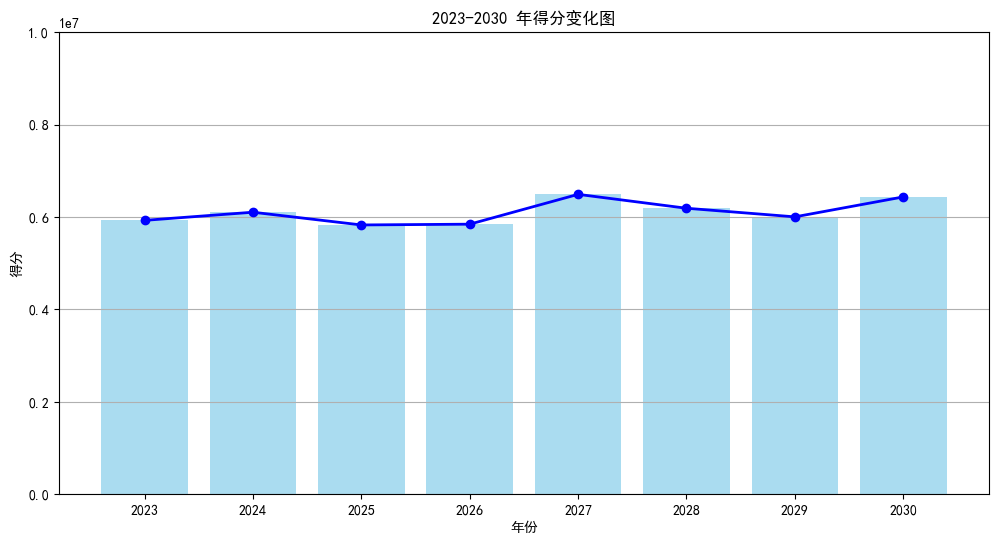

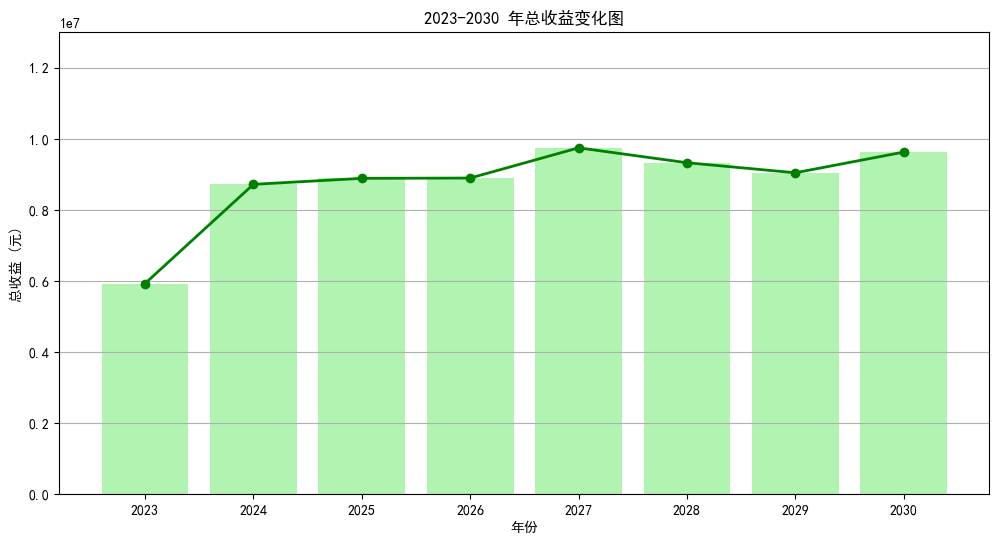

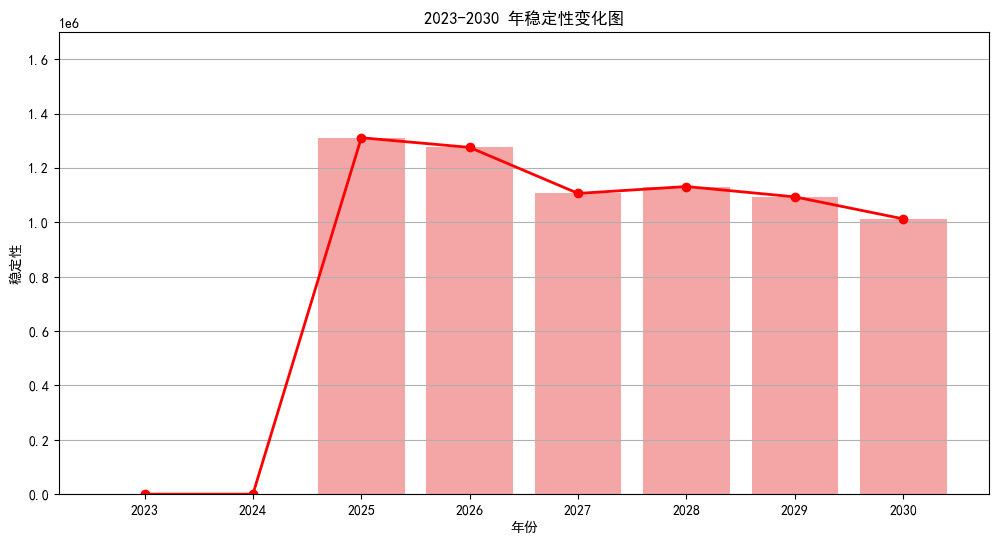

In [4]:
# 定义年份
years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

# 绘制得分变化图
plt.figure(figsize=(12, 6))
plt.bar(years, scores_max, color='skyblue', alpha=0.7)
plt.plot(years, scores_max, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年得分变化图')
plt.xlabel('年份')
plt.ylabel('得分')
plt.ylim(0, 1e7)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制总收益变化图
plt.figure(figsize=(12, 6))
plt.bar(years, profits_max, color='lightgreen', alpha=0.7)
plt.plot(years, profits_max, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年总收益变化图')
plt.xlabel('年份')
plt.ylabel('总收益 (元)')
plt.ylim(0, 1.3e7)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制稳定性变化图
plt.figure(figsize=(12, 6))
plt.bar(years, stability_max, color='lightcoral', alpha=0.7)
plt.plot(years, stability_max, color='red', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年稳定性变化图')
plt.xlabel('年份')
plt.ylabel('稳定性')
plt.ylim(0, 1.7e6)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()


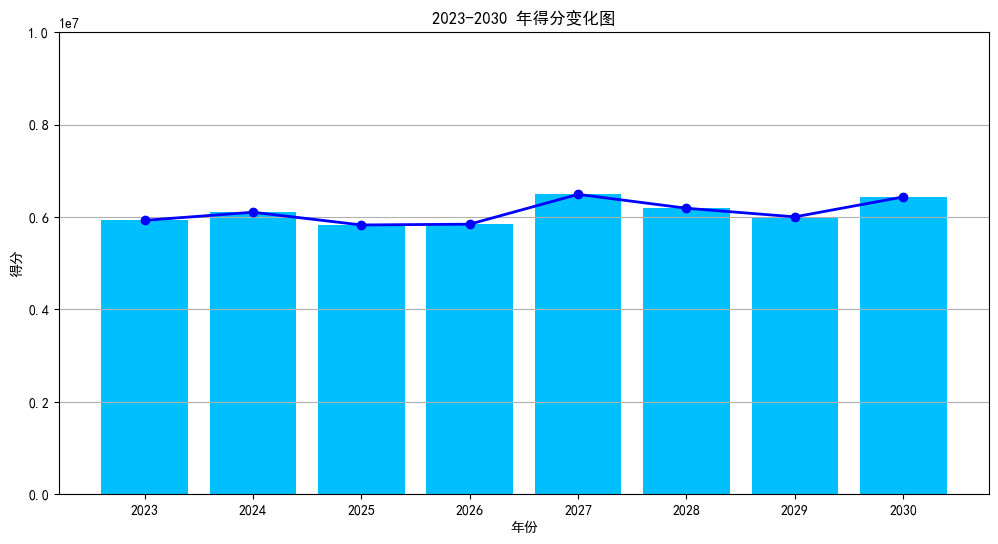

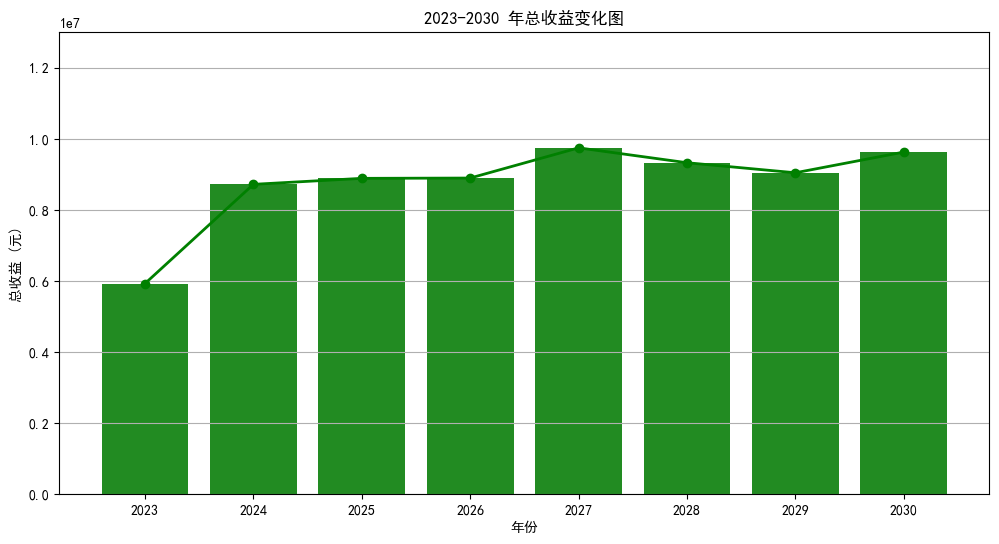

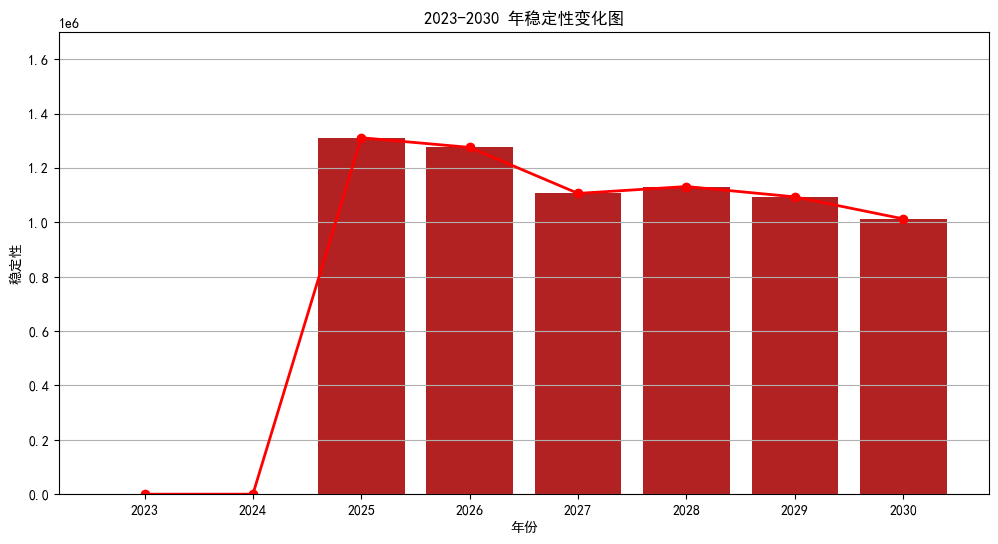

In [5]:
# 定义年份
years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

# 绘制得分变化图
plt.figure(figsize=(12, 6))
plt.bar(years, scores_max, color='deepskyblue')
plt.plot(years, scores_max, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年得分变化图')
plt.xlabel('年份')
plt.ylabel('得分')
plt.ylim(0, 1e7)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制总收益变化图
plt.figure(figsize=(12, 6))
plt.bar(years, profits_max, color='forestgreen')
plt.plot(years, profits_max, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年总收益变化图')
plt.xlabel('年份')
plt.ylabel('总收益 (元)')
plt.ylim(0, 1.3e7)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制稳定性变化图
plt.figure(figsize=(12, 6))
plt.bar(years, stability_max, color='firebrick')
plt.plot(years, stability_max, color='red', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年稳定性变化图')
plt.xlabel('年份')
plt.ylabel('稳定性')
plt.ylim(0, 1.7e6)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()


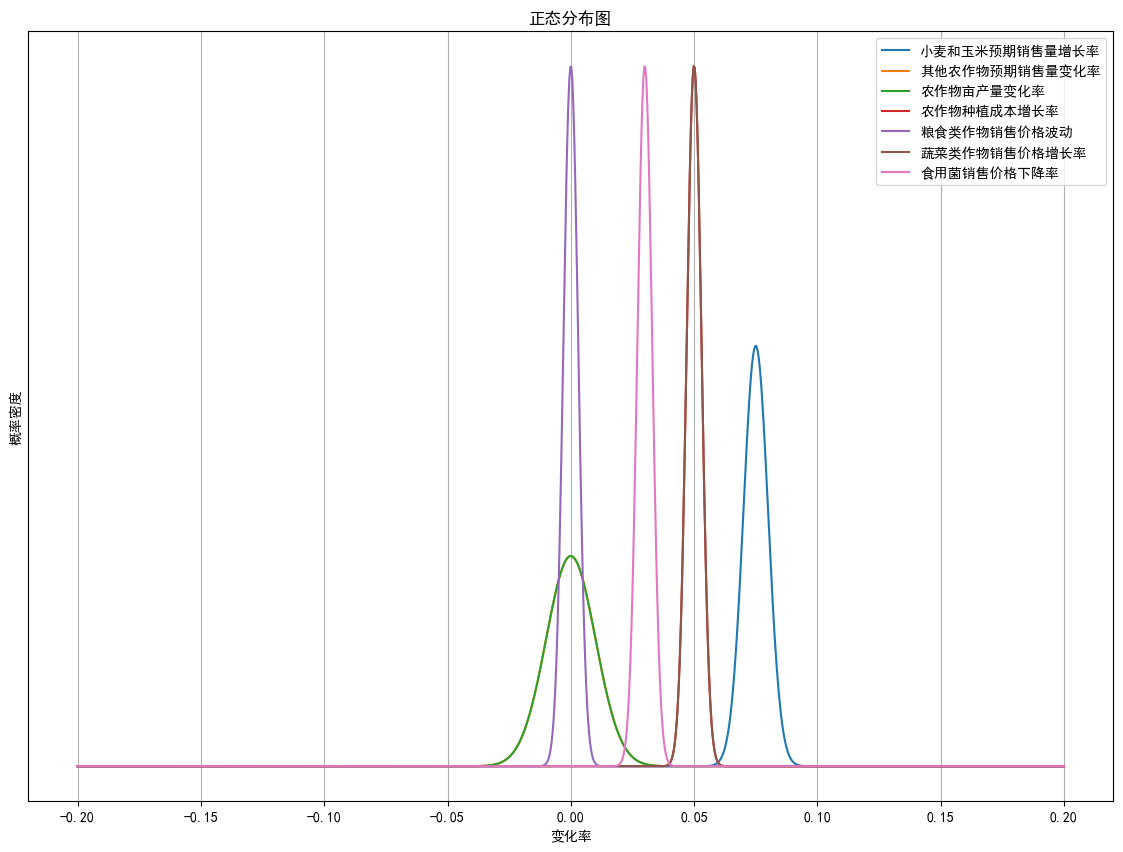

In [6]:
# 定义均值和标准差
data_info = {
    "小麦和玉米预期销售量增长率": {"mean": (0.05 + 0.10) / 2, "std": std_devs[0]},
    "其他农作物预期销售量变化率": {"mean": (0.05 - 0.05) / 2, "std": std_devs[2]},
    "农作物亩产量变化率": {"mean": (0.10 - 0.10) / 2, "std": std_devs[3]},
    "农作物种植成本增长率": {"mean": 0.05, "std": std_devs[4]},
    "粮食类作物销售价格波动": {"mean": 0, "std": std_devs[5]},
    "蔬菜类作物销售价格增长率": {"mean": 0.05, "std": std_devs[6]},
    "食用菌销售价格下降率": {"mean": (0.01 + 0.05) / 2, "std": std_devs[7]}
}

# 生成正态分布数据
x = np.linspace(-0.2, 0.2, 1000)
distributions = {key: (x, np.exp(-((x - value["mean"]) ** 2) / (2 * value["std"] ** 2)) / (value["std"] * np.sqrt(2 * np.pi))) for key, value in data_info.items()}

# 绘制正态分布图
plt.figure(figsize=(14, 10))
for key, (x, y) in distributions.items():
    plt.plot(x, y, label=key)

plt.title("正态分布图")
plt.xlabel("变化率")
plt.ylabel("概率密度")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.show()